This notebook contains some code to find relationships between the training data and the output of the models.


In [ ]:
pip install git+https://github.com/k-tonal/mimikit@berlach

In [2]:
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from mimikit.data import Database
from mimikit.analysis.trajectories import distance_to_nnbrs, find_short_trajectory

In [4]:
# convenience function to quickly get a trajectory that shows in which way the model output travels through the 
# training data space

def get_trajectory(x, db):
    X = librosa.stft(x, 2048, 512)
    Xflux = np.diff(abs(X))
    Xmag = abs(X)
    Xtrain = db.fft[:]
    dists, inds = distance_to_nnbrs(np.log(np.maximum(Xmag.T, 0.000001)), np.log(np.maximum(abs(Xtrain), 0.000001)))
    traj, cdist = find_short_trajectory(Xmag, Xtrain, dists, inds, n_trial_pathes=16)
    return inds[np.arange(len(traj)), traj]

In [8]:
# if the database is in a local location
#db = Database('./dbs/babylachen_2.h5')
#hop_length = db.fft.attrs['hop_length']
#fs = db.fft.attrs['sr']

# get the database from neptune

from mimikit import NeptuneConnector

nep_setup = dict(db="data-and-base-notebooks/DAT-29",
                 model="experiment-1/EX1-7")

nep_con = NeptuneConnector(user="k-tonal", setup=nep_setup)

# get audios
nep_con.download_experiment('model', destination="./", artifacts="audios/")

# get database
database_name = "babylachen_2.h5"
db = nep_con.download_database("db", database_name)
hop_length = db.fft.attrs['hop_length']
fs = db.fft.attrs['sr']

# convert db data to time domain (just for being able to hear it)
train_audio = librosa.griffinlim(db.fft[:].T, 32, 512)

db.metadata

start  stop  duration                                               name
0      0  3123      3123  Desktop/babylachen experimente/audiofiles/no_s...

In [11]:
import IPython.display as ipd

ipd.Audio(train_audio, rate=fs)


In [12]:
# read one of the downloaded audio files
x,fs = sf.read('./EX1-7/audios/prompt=1264.wav')
ipd.Audio(x, rate=fs)

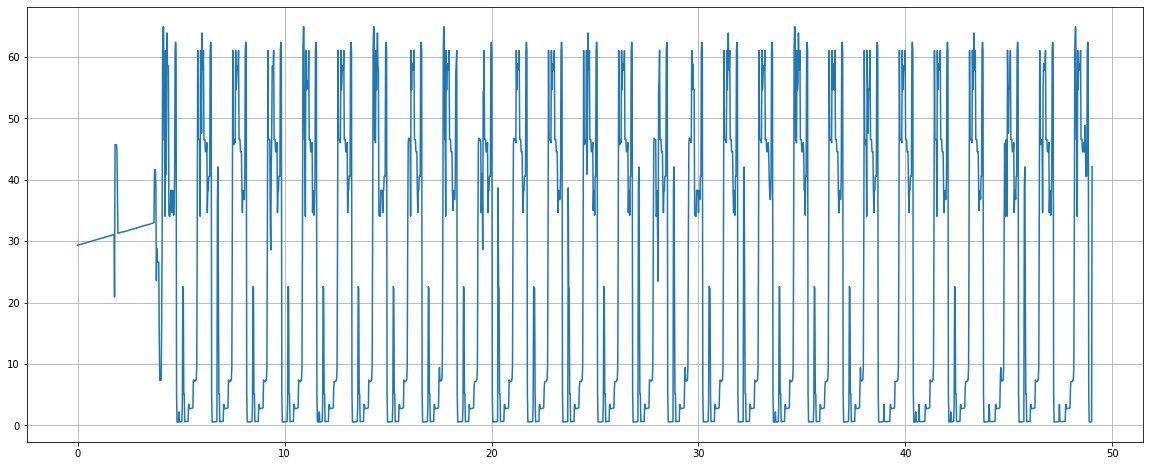

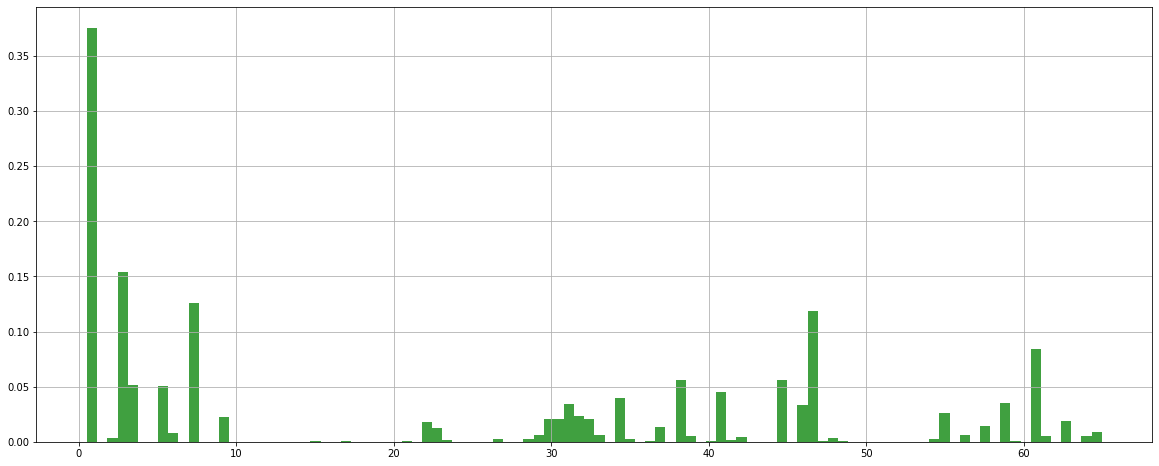

In [16]:
# plot the trajectory 
# the x axis is time in the audio file in seconds
# the y axis is the corresponding time in seconds where the training data is very similar
# the second plot is a histogram that shows how much of each time slice in the training data is covered in 
# the given model output.

traj = get_trajectory(x, db)

plt.rcParams['figure.figsize'] = (20, 8)
plt.plot(np.arange(len(traj)) * hop_length/fs, traj * hop_length/fs)
plt.grid()
plt.show()
plt.grid()
time_points = np.array(sorted(list(traj))) * hop_length/fs
n, bins, patches = plt.hist(time_points, 100, density=True, facecolor='g', alpha=0.75)

In [21]:
# load all model outputs to get a better impression of how the model relates to the data

import os
audios = [ './EX1-7/audios/' + path for path in os.listdir('./EX1-7/audios')]

traj = []

for f in audios:
    x,fs = sf.read(f)
    traj = np.concatenate([traj, get_trajectory(x, db)])


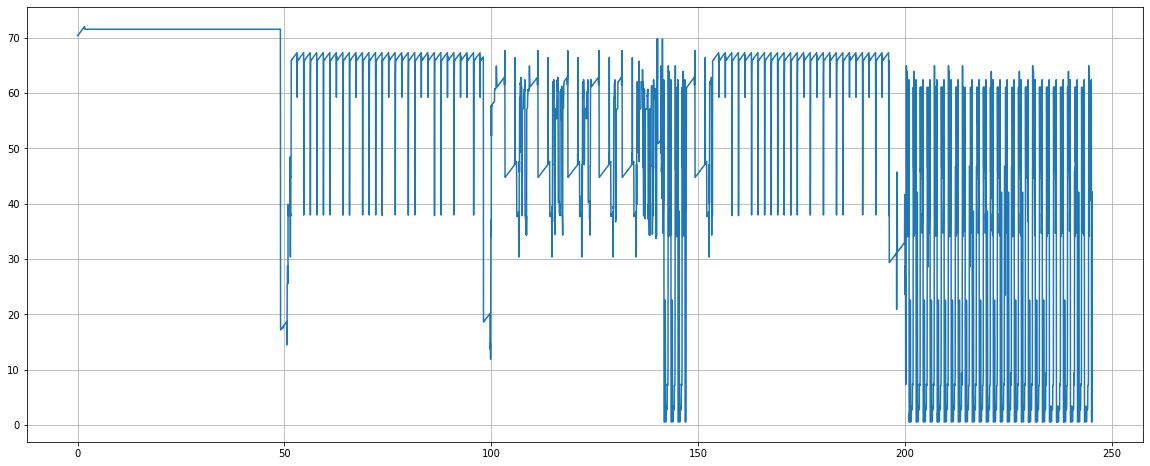

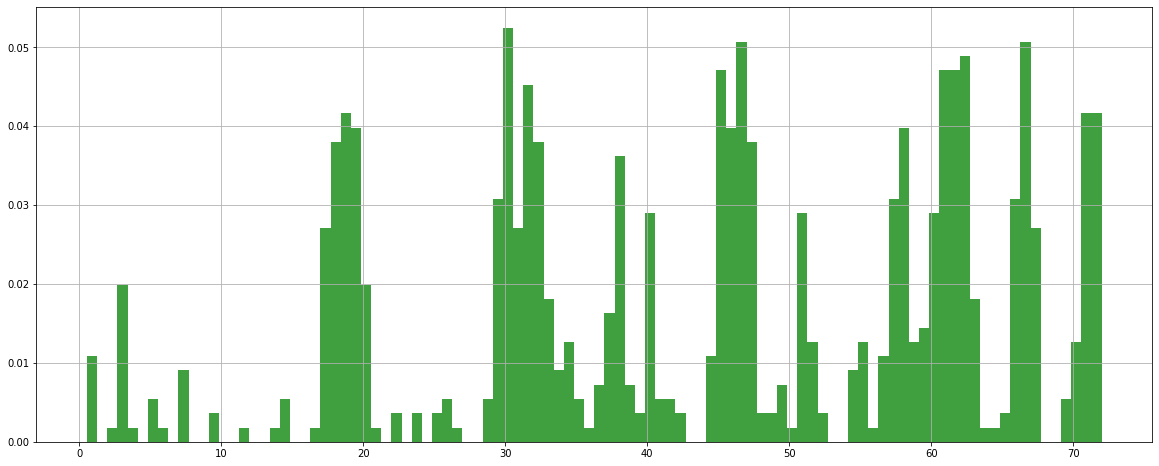

In [24]:
# plot trajectories and histogram for all the previously processed model outputs

plt.plot(np.arange(len(traj)) * hop_length/fs, traj * hop_length/fs)
plt.grid()
plt.show()
time_points = np.array(sorted(list(set(list(traj))))) * hop_length/fs
n, bins, patches = plt.hist(time_points, 100, density=True, facecolor='g', alpha=0.75)
plt.grid()